In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
from matplotlib.pyplot import figure
import seaborn as sns
from pmdarima import auto_arima
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv('Denawaka_multivariate.csv',parse_dates=['Time'], index_col='Time')
df.head()

,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Power
Time,,,,,,
2013-01-01,96.3,22.0,31.9,75.0,94.0,1633991
2013-02-01,228.3,22.5,33.5,72.0,94.0,1094607
2013-03-01,319.2,23.1,34.0,77.0,97.0,2145374
2013-04-01,280.6,24.1,34.3,76.0,97.0,4632494
2013-05-01,492.3,24.5,31.5,83.0,95.0,2567256


In [29]:
#Checking for missing values
df.isna().sum()

Rainfall     0
Temp_min     1
Temp_max     1
Hum_min      1
Hum_max     10
Power        0
dtype: int64

In [30]:
df=df.resample('MS').first()

In [31]:
#removing missing values
df=df.fillna(method='bfill')
df.head()

,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Power
Time,,,,,,
2013-01-01,96.3,22.0,31.9,75.0,94.0,1633991
2013-02-01,228.3,22.5,33.5,72.0,94.0,1094607
2013-03-01,319.2,23.1,34.0,77.0,97.0,2145374
2013-04-01,280.6,24.1,34.3,76.0,97.0,4632494
2013-05-01,492.3,24.5,31.5,83.0,95.0,2567256


In [32]:
df=df[['Temp_min','Temp_max','Hum_min','Hum_max','Rainfall']]

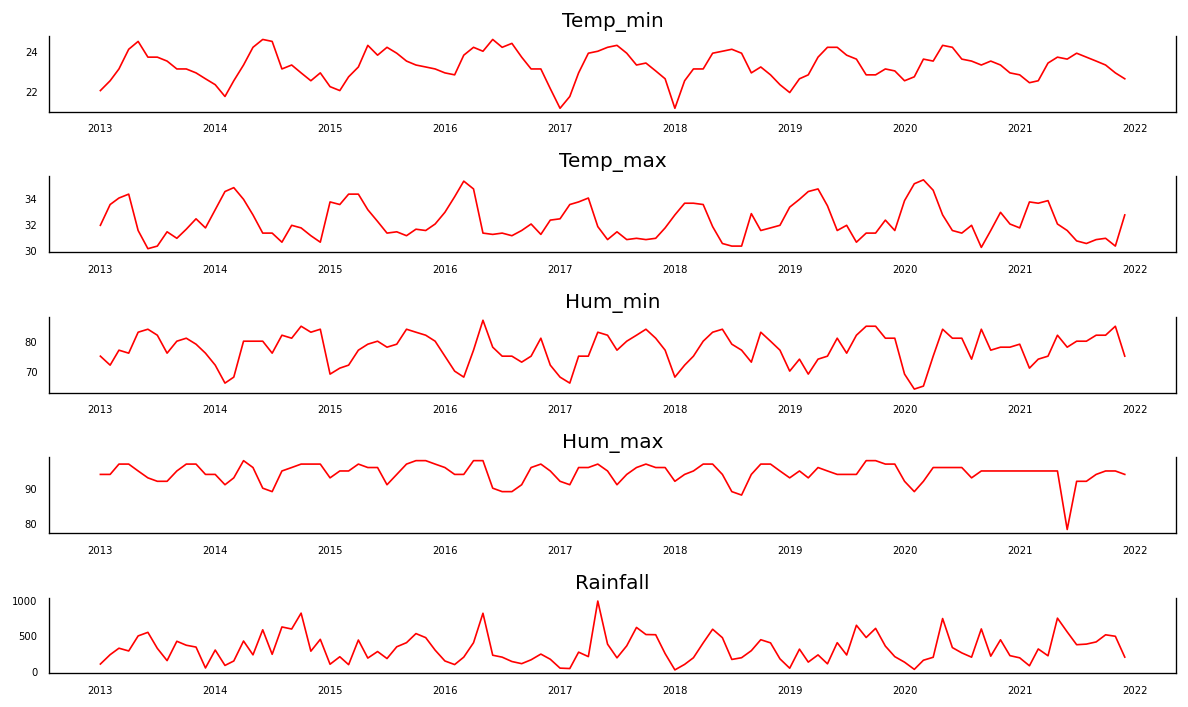

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

    H0: Series is not stationary
    H1: Series is Stationary

In [34]:
### ADF Test
col=df.columns
for i in range(len(col)):
    test_result=adfuller(df[col[i]])
    def adfuller_test(x):
        result=adfuller(x)
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
        for value,label in zip(result,labels):
            print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, "+col[i]+" series is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating " + col[i] + " series is non-stationary ")

    adfuller_test(df[col[i]])

ADF Test Statistic : -2.1280093887613822
p-value : 0.23340203111748387
#Lags Used : 12
Number of Observations Used : 95
weak evidence against null hypothesis, time series has a unit root, indicating Temp_min series is non-stationary 
ADF Test Statistic : -1.710842698239351
p-value : 0.42553482915756197
#Lags Used : 11
Number of Observations Used : 96
weak evidence against null hypothesis, time series has a unit root, indicating Temp_max series is non-stationary 
ADF Test Statistic : -3.2678433337041684
p-value : 0.01637851154600926
#Lags Used : 10
Number of Observations Used : 97
strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, Hum_min series is stationary
ADF Test Statistic : -7.579272246968896
p-value : 2.709028060645578e-11
#Lags Used : 2
Number of Observations Used : 105
strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, Hum_max series is stationary
ADF Test Statistic : -3.5080612580912716
p-value : 0.0077824

#### According to the ADF test, only the Temp_min and Temp_max series are non-stationary. Therefore it needs to difference the series.

In [35]:
ad_fuller_result_1 = adfuller(df['Temp_min'].diff()[1:])

print('Temp_min')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

Temp_min
ADF Statistic: -5.436252086972242
p-value: 2.84127705791227e-06


In [36]:
ad_fuller_result_2 = adfuller(df['Temp_max'].diff()[1:])

print('Temp_max')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Temp_max
ADF Statistic: -9.687516655860502
p-value: 1.1598777095571726e-16


In [37]:
#Combine first differenced Temp_min with rest.
df['Temp_min']=df['Temp_min'].diff()[1:]
df['Temp_max']=df['Temp_max'].diff()[1:]
#df= df.iloc[1: , :] #Remioving the first column
#Checking for missing values
df.isna().sum()

Temp_min    1
Temp_max    1
Hum_min     0
Hum_max     0
Rainfall    0
dtype: int64

In [38]:
#removing missing values
df=df.dropna(how="any")
df.head()

,Temp_min,Temp_max,Hum_min,Hum_max,Rainfall
Time,,,,,
2013-02-01,0.5,1.6,72.0,94.0,228.3
2013-03-01,0.6,0.5,77.0,97.0,319.2
2013-04-01,1.0,0.3,76.0,97.0,280.6
2013-05-01,0.4,-2.8,83.0,95.0,492.3
2013-06-01,-0.8,-1.4,84.0,93.0,542.8


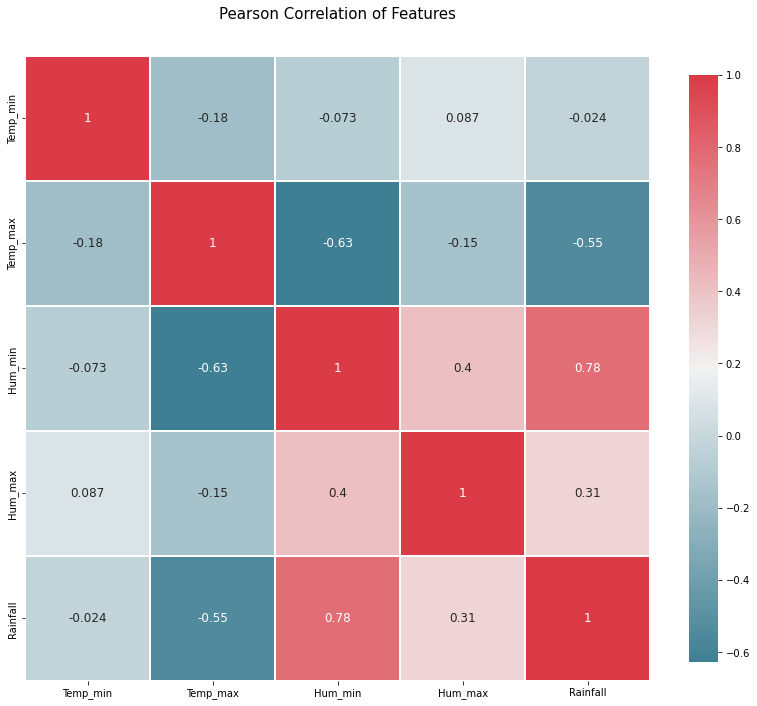

In [39]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

# Fitting ARIMAX model

In [40]:
#Re-importing dataset without setting the index on time axis.
df_1 = pd.read_csv('Denawaka_multivariate.csv')
#Removing first row
df_2= df_1.iloc[1: , :]
#Remove Temp_min, Temp_max column
df_2=df_2.drop(columns=['Temp_min','Temp_max'])

#Concat the dataframe with first differenced Temp_min with first row removed dataframe
df=pd.concat([df_2,df_1['Temp_min'].diff()[1:],df_1['Temp_max'].diff()[1:]],axis=1)
#removing missing values
df=df.dropna(how="any")
df.head()

,Rainfall,Hum_min,Hum_max,Time,Power,Temp_min,Temp_max
1,228.3,72.0,94.0,2013-February,1094607,0.5,1.6
2,319.2,77.0,97.0,2013-March,2145374,0.6,0.5
3,280.6,76.0,97.0,2013-April,4632494,1.0,0.3
4,492.3,83.0,95.0,2013-May,2567256,0.4,-2.8
5,542.8,84.0,93.0,2013-June,4305650,-0.8,-1.4


### Feature Engineering

In [41]:
def feature_engineering(data):
    data['Time'] = pd.to_datetime(data['Time'])
    data["Time"] = pd.to_datetime(data["Time"], format="%Y-%m-%d")
    data["year"] = data["Time"].dt.year
    data["month"] = data["Time"].dt.month
    
    lag_features = ["Rainfall","Temp_min","Temp_max","Hum_min","Hum_max"]
    window1 = 2
    window2 = 3
    window3 = 7

    data_rolled_2d = data[lag_features].rolling(window=window1, min_periods=0)
    data_rolled_3d = data[lag_features].rolling(window=window2, min_periods=0)
    data_rolled_7d = data[lag_features].rolling(window=window3, min_periods=0)

    data_mean_2d = data_rolled_2d.mean().shift(1)
    data_mean_3d = data_rolled_3d.mean().shift(1)
    data_mean_7d = data_rolled_7d.mean().shift(1)
    
    data_std_2d = data_rolled_2d.std().shift(1)
    data_std_3d = data_rolled_3d.std().shift(1)
    data_std_7d = data_rolled_7d.std().shift(1)

    for feature in lag_features:
        data[f"{feature}_mean_lag{window1}"] = data_mean_2d[feature]
        data[f"{feature}_mean_lag{window2}"] = data_mean_3d[feature]
        data[f"{feature}_mean_lag{window3}"] = data_mean_7d[feature]

        data[f"{feature}_std_lag{window1}"] = data_std_2d[feature]
        data[f"{feature}_std_lag{window2}"] = data_std_3d[feature]
        data[f"{feature}_std_lag{window3}"] = data_std_7d[feature]

    data.fillna(data.mean(), inplace=True)
    
feature_engineering(df)

In [42]:
df.head()

,Rainfall,Hum_min,Hum_max,Time,Power,Temp_min,Temp_max,year,month,Rainfall_mean_lag2,...,Hum_min_mean_lag7,Hum_min_std_lag2,Hum_min_std_lag3,Hum_min_std_lag7,Hum_max_mean_lag2,Hum_max_mean_lag3,Hum_max_mean_lag7,Hum_max_std_lag2,Hum_max_std_lag3,Hum_max_std_lag7
1,228.3,72.0,94.0,2013-02-01,1094607,0.5,1.6,2013,2,311.846842,...,77.114737,2.911174,3.625532,4.837454,94.278947,94.278947,94.342581,1.587229,2.137637,2.671525
2,319.2,77.0,97.0,2013-03-01,2145374,0.6,0.5,2013,3,228.300000,...,72.000000,2.911174,3.625532,4.837454,94.000000,94.000000,94.000000,1.587229,2.137637,2.671525
3,280.6,76.0,97.0,2013-04-01,4632494,1.0,0.3,2013,4,273.750000,...,74.500000,3.535534,3.535534,3.535534,95.500000,95.500000,95.500000,2.121320,2.121320,2.121320
4,492.3,83.0,95.0,2013-05-01,2567256,0.4,-2.8,2013,5,299.900000,...,75.000000,0.707107,2.645751,2.645751,97.000000,96.000000,96.000000,0.000000,1.732051,1.732051
5,542.8,84.0,93.0,2013-06-01,4305650,-0.8,-1.4,2013,6,386.450000,...,77.000000,4.949747,3.785939,4.546061,96.000000,96.333333,95.750000,1.414214,1.154701,1.500000


In [43]:
#Checking for missing values
df.isnull().sum()

Rainfall              0
Hum_min               0
Hum_max               0
Time                  0
Power                 0
Temp_min              0
Temp_max              0
year                  0
month                 0
Rainfall_mean_lag2    0
Rainfall_mean_lag3    0
Rainfall_mean_lag7    0
Rainfall_std_lag2     0
Rainfall_std_lag3     0
Rainfall_std_lag7     0
Temp_min_mean_lag2    0
Temp_min_mean_lag3    0
Temp_min_mean_lag7    0
Temp_min_std_lag2     0
Temp_min_std_lag3     0
Temp_min_std_lag7     0
Temp_max_mean_lag2    0
Temp_max_mean_lag3    0
Temp_max_mean_lag7    0
Temp_max_std_lag2     0
Temp_max_std_lag3     0
Temp_max_std_lag7     0
Hum_min_mean_lag2     0
Hum_min_mean_lag3     0
Hum_min_mean_lag7     0
Hum_min_std_lag2      0
Hum_min_std_lag3      0
Hum_min_std_lag7      0
Hum_max_mean_lag2     0
Hum_max_mean_lag3     0
Hum_max_mean_lag7     0
Hum_max_std_lag2      0
Hum_max_std_lag3      0
Hum_max_std_lag7      0
dtype: int64

In [44]:
#Splitting the data set to train and test
train=df[:int(0.67*(len(df)))]
valid=df[int(0.67*(len(df))):]

In [45]:
features=df.columns
print(features)

Index(['Rainfall', 'Hum_min', 'Hum_max', 'Time', 'Power', 'Temp_min',
       'Temp_max', 'year', 'month', 'Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7'],
      dtype='object')


In [46]:
#Removing predictor variable and time column
features=['Hum_min', 'Hum_max', 'Temp_min',
       'Temp_max','Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7']

In [47]:
arimaxmodel = auto_arima(train['Rainfall'],
                   exogenous = train[features], trace=True, 
                   error_action="ignore", suppress_warnings=True,stepwise=False,max_d=2,max_D=2,m=12,max_p=6,max_q=6,maxiter=70,alpha=0.05,
                        n_jobs=-1,)
arimaxmodel.fit(train['Rainfall'], exogenous = train[features])
# model = arima()
arimaxforecast = arimaxmodel.predict(n_periods=len(valid), exogenous = valid[features])
valid["Forecast_ARIMAX"] = arimaxforecast


Best model:  ARIMA(0,0,0)(0,0,2)[12] intercept
Total fit time: 208.599 seconds


In [48]:
arimaxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                   64
Model:             SARIMAX(0, 0, [1, 2], 12)   Log Likelihood                -360.074
Date:                       Sun, 24 Apr 2022   AIC                            796.148
Time:                               23:47:26   BIC                            878.185
Sample:                                    0   HQIC                           828.467
                                        - 64                                         
Covariance Type:                         opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept              0.0263   6816.783   3.85e-06      1.000   -1.34e+04    1.34e+04
Hum_min               58.0059     23.190      2.501      0.012      12.554     103.458
Hum_max              -22.1612     29.612     -0.748      0.454     -80.199      35.877
Temp_min            -108.5372     70.975     -1.529      0.126    -247.646      30.572
Temp_max              78.3664     70.049      1.119      0.263     -58.926     215.659
Rainfall_mean_lag2    -0.0271      0.643     -0.042      0.966      -1.287       1.233
Rainfall_mean_lag3    -1.0076      0.948     -1.063      0.288      -2.866       0.850
Rainfall_mean_lag7     2.0995      1.560      1.346      0.178      -0.957       5.156
Rainfall_std_lag2     -0.0222      0.511     -0.043      0.965      -1.025       0.980
Rainfall_std_lag3     -0.1868      0.864     -0.216      0.829      -1.880       1.506
Rainfall_std_lag7     -0.9469      0.763     -1.242      0.214      -2.442       0.548
Temp_min_mean_lag2   -14.3665    126.918     -0.113      0.910    -263.122     234.389
Temp_min_mean_lag3    66.2858    183.007      0.362      0.717    -292.402     424.974
Temp_min_mean_lag7  -532.1578    370.603     -1.436      0.151   -1258.527     194.211
Temp_min_std_lag2    136.1863    122.187      1.115      0.265    -103.296     375.669
Temp_min_std_lag3   -338.8475    198.312     -1.709      0.088    -727.532      49.837
Temp_min_std_lag7    -42.8121    299.762     -0.143      0.886    -630.336     544.711
Temp_max_mean_lag2     5.9241    205.503      0.029      0.977    -396.854     408.702
Temp_max_mean_lag3    56.0234    273.571      0.205      0.838    -480.166     592.212
Temp_max_mean_lag7    50.1084    276.501      0.181      0.856    -491.823     592.039
Temp_max_std_lag2    -27.3526     96.748     -0.283      0.777    -216.976     162.271
Temp_max_std_lag3    115.2094    185.390      0.621      0.534    -248.149     478.567
Temp_max_std_lag7   -264.3816    126.173     -2.095      0.036    -511.677     -17.086
Hum_min_mean_lag2     -0.1499     65.196     -0.002      0.998    -127.931     127.631
Hum_min_mean_lag3     39.9899     78.070      0.512      0.608    -113.024     193.003
Hum_min_mean_lag7    -93.7112     72.244     -1.297      0.195    -235.306      47.884
Hum_min_std_lag2      11.6807     26.779      0.436      0.663     -40.806      64.167
Hum_min_std_lag3     -14.0235     35.630     -0.394      0.694     -83.857      55.810
Hum_min_std_lag7      57.9399     57.879      1.001      0.317     -55.501     171.381
Hum_max_mean_lag2     51.5425     75.016      0.687      0.492     -95.486     198.571
Hum_max_mean_lag3    -69.9018     98.329     -0.711      0.477    -262.623     122.819
Hum_max_mean_lag7     39.8099     88.329      0.451      0.652    -133.311     212.931
Hum_max_std_lag2     -12.1111     29.926     -0.405      0.686     -70.765      46.543
Hum_max_std_lag3      29.0566     48.637      

Text(0.5, 1.0, 'Rainfall Forecasting')

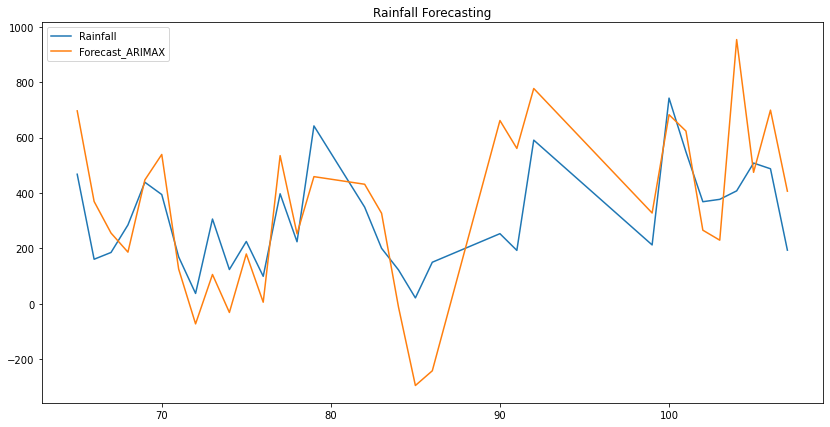

In [49]:
#Forecast using built model
valid[["Rainfall", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
plt.title('Rainfall Forecasting')

In [50]:
#Re modling

In [51]:
#Removing predictor variable and time column
features=['Hum_min', 'Hum_max', 'Temp_min',
       'Temp_max','Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7']

In [52]:
arimaxmodel = auto_arima(train['Rainfall'],
                   exogenous = train[features], trace=True, 
                   error_action="ignore", suppress_warnings=True,stepwise=False,start_P=1,start_Q=1,max_d=2,max_D=2,m=12,max_p=6,max_q=6,maxiter=70,alpha=0.05
                        )
arimaxmodel.fit(train['Rainfall'], exogenous = train[features])
# model = arima()
arimaxforecast = arimaxmodel.predict(n_periods=len(valid), exogenous = valid[features])
valid["Forecast_ARIMAX"] = arimaxforecast

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=800.092, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=801.651, Time=2.09 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=801.970, Time=2.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=800.122, Time=2.65 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=797.706, Time=4.53 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=798.198, Time=6.57 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=798.936, Time=11.33 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=802.085, Time=2.66 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=803.472, Time=6.04 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=7.87 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=803.964, Time=3.21 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.89 sec
 ARIMA(0,0,1)(2,0,0)[12] inte